In [1]:
import torch
import pickle, time

/home/su/perfpred/torch_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import dgl
dgl.__version__

'0.10'

In [4]:
dataset_file = 'nas_graphs.data'

def load_data_raw(filename):
    with open(filename, 'rb') as f:
        raw_data = pickle.load(f)
    return raw_data

t0 = time.time()
raw_data = load_data_raw(dataset_file)
dur = time.time() - t0

print(f"dataset loaded, cost {dur} s")

dataset loaded, cost 289.8015818595886 s


In [5]:
# construct graphs
graphs = []
labels = []

# transform type node_type into onehot
n_ntypes = 0
for node_type, _, _, _, _ in raw_data:
#     print(node_type)
    max_node_type = max(node_type)
    n_ntypes = max(n_ntypes, max_node_type)
n_ntypes += 1

for node_type, node_data, edge_list, edge_data, mem in raw_data:
    edge_list_tensor = torch.LongTensor(edge_list)
    node_type_tensor = torch.nn.functional.one_hot(torch.tensor(node_type), n_ntypes)
    ndata = torch.stack(node_data)
#     print(ndata.shape, node_type_tensor.shape)
    ndata = torch.concat([node_type_tensor, ndata], dim=1)
#     print(ndata.shape)
    edata = torch.tensor(edge_data)
    g = dgl.graph((edge_list_tensor[:, 0], edge_list_tensor[:, 1]))
    g.ndata['feat'] = ndata
    g.edata['feat'] = edata.float()
    graphs.append(g)
    labels.append(mem)
    
labels = torch.tensor(labels)

In [6]:
# backup
with open("nas_graphs_dgl.data", "wb") as f:
    pickle.dump([graphs, labels], f)

In [12]:
with open("nas_graphs_dgl.data", "rb") as f:
    graphs, labels = pickle.load(f)


(array([  12.,  161.,  643., 1534., 1150., 2359., 1852., 1020.,  295.,
          36.]),
 array([ 590.,  698.,  806.,  914., 1022., 1130., 1238., 1346., 1454.,
        1562., 1670.]),
 <BarContainer object of 10 artists>)

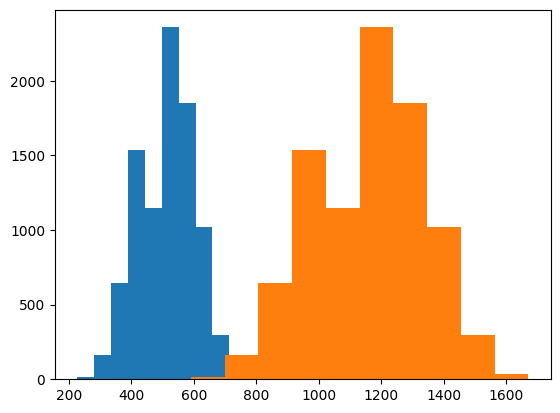

In [7]:
from matplotlib import pyplot as plt
num_nodes = [g.num_nodes() for g in graphs]
num_edges = [g.num_edges() for g in graphs]

plt.hist(num_nodes)
plt.hist(num_edges)

In [13]:
# normalize
num_ndata = graphs[0].ndata['feat'].shape[1]
num_edata = graphs[0].edata['feat'].shape[1]

max_ndata = []
min_ndata = []
max_edata = []
min_edata = []

for ndata_id in range(num_ndata):
    max_v = graphs[0].ndata['feat'][0, ndata_id]
    min_v = graphs[0].ndata['feat'][0, ndata_id]
    for g in graphs:
        max_v = max(max_v, torch.max(g.ndata['feat'][:, ndata_id]))
        min_v = min(min_v, torch.min(g.ndata['feat'][:, ndata_id]))
    if max_v != min_v:
        for g in graphs:
            g.ndata['feat'][:, ndata_id] = (g.ndata['feat'][:, ndata_id] - min_v)/(max_v - min_v)
    max_ndata.append(max_v)
    min_ndata.append(min_v)
            
for edata_id in range(num_edata):
    max_v = graphs[0].edata['feat'][0, edata_id]
    min_v = graphs[0].edata['feat'][0, edata_id]
    for g in graphs:
        max_v = max(max_v, torch.max(g.edata['feat'][:, edata_id]))
        min_v = min(min_v, torch.min(g.edata['feat'][:, edata_id]))
    if max_v != min_v:
        for g in graphs:
            g.edata['feat'][:, edata_id] = (g.edata['feat'][:, edata_id] - min_v)/(max_v - min_v)
    max_edata.append(max_v)
    min_edata.append(min_v)

In [3]:
from torch import nn
from torch.nn import functional as F

class ANEELayer(nn.Module):
    def __init__(self, ndim, edim, nlayers):
        super(ANEELayer, self).__init__()
        self.ndim = ndim
        self.edim = edim
        self.nlayers = nlayers
        
        self.Wu = nn.Parameter(torch.randn((ndim, ndim)))
        self.We = nn.Parameter(torch.randn((edim, edim)))
        self.a = nn.Parameter(torch.randn(2 * ndim))
        self.Wm = nn.Parameter(torch.randn(edim))
        
        self.W = nn.Parameter(torch.randn((ndim, )))
    
    def forward(self, g, ndata, edata):
        for i in range(self.nlayers):
            ndata = F.leaky_relu(ndata.matmul(self.Wu))
            u, v = g.edges(form='uv')
            uv_feat = torch.concat([ndata[u, :], ndata[v, :]], dim=-1)

            new_edata = F.sigmoid(uv_feat.matmul(self.a).unsqueeze(1) * (edata.matmul(self.We)))
            Wme = F.sigmoid(new_edata.matmul(self.Wm))
            new_ndata = dgl.ops.u_mul_e_sum(g, ndata, Wme)
            new_ndata = F.leaky_relu(new_ndata)
            ndata = new_ndata
            edata = new_edata
        ndata_sum = ndata.sum(dim=0)
        out = ndata_sum.matmul(self.W)
        
        return out

In [7]:
model = ANEELayer(44, 2, 2)
model(graphs[0], graphs[0].ndata['feat'], graphs[0].edata['feat'])

/home/su/perfpred/torch_env/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-3627.4238, grad_fn=<DotBackward0>)

In [2]:
from tqdm import tqdm
import numpy as np

device='cuda'

model = ANEELayer(44, 2, 2)
model.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)


graphs_gpu = [g.to(device) for g in graphs]


NameError: name 'torch' is not defined

indices = np.random.permutation(range(len(graphs)))
n_train = int(0.7 * len(graphs))
train_indices = indices[:n_train]

In [9]:
np.savez("dataset_index.npz", train_id=train_indices, test_id=indices[n_train:])

In [9]:
indices = np.load("dataset_index.npz")
train_indices = indices['train_id']
test_indices = indices['test_id']

In [11]:
indices[n_train:]

array([7451,  765, 4626, ...,  835, 3958, 8849])

In [10]:
for epoch in range(80):
    errs = []
    idx = np.random.permutation(range(len(train_indices))) 
    for i in tqdm(idx):
        g = graphs_gpu[train_indices[i]]
        label = labels[train_indices[i]].to(device)
        optim.zero_grad()
        out = model(g, g.ndata['feat'], g.edata['feat'])
        err = torch.abs(out - label) / label
        errs.append(err.cpu().detach().numpy())
        loss = loss_fn(out, label)
        loss.backward()
        optim.step()
    #     print(loss)
    print(np.mean(errs))

100%|██████████| 6343/6343 [00:51<00:00, 122.76it/s]


0.63554746


100%|██████████| 6343/6343 [00:44<00:00, 143.91it/s]


0.29605097


100%|██████████| 6343/6343 [00:42<00:00, 147.63it/s]


0.16889216


100%|██████████| 6343/6343 [00:40<00:00, 156.19it/s]


0.12937088


100%|██████████| 6343/6343 [00:40<00:00, 155.05it/s]


0.109828


100%|██████████| 6343/6343 [00:40<00:00, 155.23it/s]


0.09721223


100%|██████████| 6343/6343 [00:40<00:00, 156.68it/s]


0.08966379


100%|██████████| 6343/6343 [00:40<00:00, 156.19it/s]


0.08414478


100%|██████████| 6343/6343 [00:40<00:00, 155.11it/s]


0.08038378


100%|██████████| 6343/6343 [00:41<00:00, 154.57it/s]


0.077186555


100%|██████████| 6343/6343 [00:40<00:00, 155.22it/s]


0.07605001


100%|██████████| 6343/6343 [00:40<00:00, 156.96it/s]


0.07439971


100%|██████████| 6343/6343 [00:40<00:00, 155.08it/s]


0.07341724


100%|██████████| 6343/6343 [00:40<00:00, 155.86it/s]


0.072712965


100%|██████████| 6343/6343 [00:41<00:00, 154.42it/s]


0.07182976


100%|██████████| 6343/6343 [00:40<00:00, 155.04it/s]


0.071007065


100%|██████████| 6343/6343 [00:40<00:00, 155.66it/s]


0.07083144


100%|██████████| 6343/6343 [00:40<00:00, 157.81it/s]


0.0701189


100%|██████████| 6343/6343 [00:40<00:00, 156.46it/s]


0.069280624


100%|██████████| 6343/6343 [00:40<00:00, 155.44it/s]


0.06868883


100%|██████████| 6343/6343 [00:40<00:00, 155.22it/s]


0.067668416


100%|██████████| 6343/6343 [00:41<00:00, 154.63it/s]


0.066855215


100%|██████████| 6343/6343 [00:40<00:00, 155.31it/s]


0.06597059


100%|██████████| 6343/6343 [00:40<00:00, 155.53it/s]


0.06515914


100%|██████████| 6343/6343 [00:40<00:00, 155.55it/s]


0.06386307


100%|██████████| 6343/6343 [00:40<00:00, 155.52it/s]


0.063043855


100%|██████████| 6343/6343 [00:40<00:00, 155.75it/s]


0.061753027


100%|██████████| 6343/6343 [00:40<00:00, 155.76it/s]


0.060642965


100%|██████████| 6343/6343 [00:40<00:00, 155.72it/s]


0.058885172


100%|██████████| 6343/6343 [00:40<00:00, 155.79it/s]


0.057793908


100%|██████████| 6343/6343 [00:41<00:00, 154.34it/s]


0.05680502


100%|██████████| 6343/6343 [00:41<00:00, 154.49it/s]


0.055272456


100%|██████████| 6343/6343 [00:40<00:00, 155.27it/s]


0.054543875


100%|██████████| 6343/6343 [00:40<00:00, 156.33it/s]


0.053266574


100%|██████████| 6343/6343 [00:41<00:00, 152.49it/s]


0.052218623


100%|██████████| 6343/6343 [00:40<00:00, 154.78it/s]


0.05105589


100%|██████████| 6343/6343 [00:40<00:00, 155.44it/s]


0.05036514


100%|██████████| 6343/6343 [00:40<00:00, 154.98it/s]


0.049543526


100%|██████████| 6343/6343 [00:41<00:00, 154.40it/s]


0.04891828


100%|██████████| 6343/6343 [00:41<00:00, 153.09it/s]


0.04810612


100%|██████████| 6343/6343 [00:40<00:00, 155.46it/s]


0.047634225


100%|██████████| 6343/6343 [00:40<00:00, 155.51it/s]


0.04695407


100%|██████████| 6343/6343 [00:41<00:00, 152.92it/s]


0.04652661


100%|██████████| 6343/6343 [00:41<00:00, 153.80it/s]


0.04574738


100%|██████████| 6343/6343 [00:41<00:00, 154.34it/s]


0.045446105


100%|██████████| 6343/6343 [00:41<00:00, 154.18it/s]


0.044803653


100%|██████████| 6343/6343 [00:40<00:00, 155.38it/s]


0.044351675


100%|██████████| 6343/6343 [00:40<00:00, 156.46it/s]


0.043910567


100%|██████████| 6343/6343 [00:41<00:00, 154.50it/s]


0.04357405


100%|██████████| 6343/6343 [00:40<00:00, 155.77it/s]


0.043089636


100%|██████████| 6343/6343 [00:40<00:00, 155.52it/s]


0.04271312


100%|██████████| 6343/6343 [00:41<00:00, 153.96it/s]


0.042015597


100%|██████████| 6343/6343 [00:41<00:00, 154.63it/s]


0.04163991


100%|██████████| 6343/6343 [00:40<00:00, 154.95it/s]


0.041404102


100%|██████████| 6343/6343 [00:40<00:00, 155.62it/s]


0.040797196


100%|██████████| 6343/6343 [00:40<00:00, 156.61it/s]


0.040356338


100%|██████████| 6343/6343 [00:40<00:00, 156.99it/s]


0.04025537


100%|██████████| 6343/6343 [00:40<00:00, 157.25it/s]


0.03976658


100%|██████████| 6343/6343 [00:40<00:00, 155.81it/s]


0.039364953


100%|██████████| 6343/6343 [00:40<00:00, 155.06it/s]


0.03916225


100%|██████████| 6343/6343 [00:41<00:00, 154.59it/s]


0.038693253


100%|██████████| 6343/6343 [00:41<00:00, 154.03it/s]


0.038546246


100%|██████████| 6343/6343 [00:40<00:00, 154.71it/s]


0.038077056


100%|██████████| 6343/6343 [00:41<00:00, 153.95it/s]


0.037667006


100%|██████████| 6343/6343 [00:40<00:00, 154.81it/s]


0.037313964


100%|██████████| 6343/6343 [00:40<00:00, 155.06it/s]


0.036997903


100%|██████████| 6343/6343 [00:40<00:00, 156.65it/s]


0.036949642


100%|██████████| 6343/6343 [00:40<00:00, 156.06it/s]


0.03657948


100%|██████████| 6343/6343 [00:40<00:00, 155.18it/s]


0.036255334


100%|██████████| 6343/6343 [00:40<00:00, 155.39it/s]


0.036083374


100%|██████████| 6343/6343 [00:40<00:00, 155.19it/s]


0.03591444


100%|██████████| 6343/6343 [00:41<00:00, 154.63it/s]


0.035599865


100%|██████████| 6343/6343 [00:40<00:00, 155.60it/s]


0.03521371


100%|██████████| 6343/6343 [00:40<00:00, 155.10it/s]


0.035236523


100%|██████████| 6343/6343 [00:41<00:00, 154.55it/s]


0.03468699


100%|██████████| 6343/6343 [00:40<00:00, 155.24it/s]


0.034378998


100%|██████████| 6343/6343 [00:40<00:00, 155.49it/s]


0.034028184


100%|██████████| 6343/6343 [00:40<00:00, 156.52it/s]


0.03364528


100%|██████████| 6343/6343 [00:40<00:00, 155.79it/s]


0.033428185


100%|██████████| 6343/6343 [00:41<00:00, 153.75it/s]

0.033243112


In [15]:
errs = []
for i in tqdm(test_indices):
    g = graphs_gpu[i]
    label = labels[i].to(device)
    with torch.no_grad():
        out = model(g, g.ndata['feat'], g.edata['feat'])
    err = torch.abs(out - label) / (label)
    errs.append(err.cpu().detach().item())
print(np.mean(errs))

100%|██████████| 2719/2719 [00:03<00:00, 694.53it/s]

0.03256110330094828


In [14]:
torch.save((model, max_ndata, min_ndata, max_edata, min_edata), "gnn_model.th")

In [4]:
from trace import Graph
import torch, dgl
import torchvision
import gc
device = 'cuda'

In [5]:
model, max_ndata, min_ndata, max_edata, min_edata = torch.load("gnn_model.th")

In [6]:
def test(example, batch_size):
    example.to(device)
    inputs = torch.rand((batch_size, 3, 224, 224), device=device)
    out = example(inputs)
    raw_g = Graph(out)
    node_type, node_data, edge_list, edge_data = raw_g.encode()
    edge_list_tensor = torch.LongTensor(edge_list)
    node_type_tensor = torch.nn.functional.one_hot(torch.tensor(node_type), 24)
    ndata = torch.stack(node_data)
    ndata = torch.concat([node_type_tensor, ndata], dim=1)
    edata = torch.tensor(edge_data)

    g = dgl.graph((edge_list_tensor[:, 0], edge_list_tensor[:, 1]))

    g.ndata['feat'] = ndata
    g.edata['feat'] = edata.float()

    for i in range(len(max_ndata)):
        if max_ndata[i] != min_ndata[i]:
            g.ndata['feat'][:, i] = (g.ndata['feat'][:, i] - min_ndata[i]) / (max_ndata[i] - min_ndata[i])
            
    for i in range(len(max_edata)):
        if max_edata[i] != min_edata[i]:
            g.edata['feat'][:, i] = (g.edata['feat'][:, i] - min_edata[i]) / (max_edata[i] - min_edata[i])

    g = g.to(device)
    with torch.no_grad():
        ret = model(g, g.ndata['feat'].cuda(), g.edata['feat'].cuda())
    return ret.cpu().numpy()

In [9]:
for bs in [8, 16, 32]:
    gc.collect()
    print('resnet18', bs, test(torchvision.models.resnet18(), bs))

/home/su/perfpred/dnnperf/trace.py:566: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_feat = torch.tensor(node.hyperparameter_info())
/home/su/perfpred/torch_env/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#node: 137 #edge: 293
resnet50 8 1664.4763
#node: 137 #edge: 293
resnet50 16 1853.0332
#node: 137 #edge: 293
resnet50 32 2214.9097


In [73]:
# normalize
#max_ndata = []
#min_ndata = []
#max_edata = []
#min_edata = []



tensor(-288.9028, device='cuda:0', grad_fn=<DotBackward0>)

In [110]:
graphs[0].num_edges()

1010